In [1]:
import numpy as np
# navigation mdp
from navigation_mdp.state import DiscreteStateSpace
from navigation_mdp.class_ import XYClassDistribution
from navigation_mdp.features import FeatureClassImageSampler
from navigation_mdp.reward import RewardStateScalar
from navigation_mdp.dynamics import XYDynamics

# navigation vis
from navigation_vis.Raster import Raster as NavGridView

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Features

In [2]:
import torchvision
cifar = torchvision.datasets.CIFAR100(root="../datasets/", download=True)
X, y = cifar.data, np.asarray(cifar.targets)
classes = np.unique(y)
n_classes = len(classes)

print(X.shape, y.shape)

def sample_image(X, y, y_q):
    x_q = X[y == y_q]
    return x_q[np.random.randint(0, len(x_q))]

Files already downloaded and verified
(50000, 32, 32, 3) (50000,)


## Navigation MDP

In [3]:
np.random.seed(5)
# Specify state space
S = DiscreteStateSpace(5,5)

# Attach classes
S.attach_classes(
    
    XYClassDistribution([
        
        [0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0]],
        marker_to_class_id = {
            1: 76,
            0: 68
        },
    )().flatten()
)

# Attach features
S.attach_features(FeatureClassImageSampler(S, lambda x: sample_image(X, y, x)))

# For visualization
PHI_gridded = S.features(gridded=True)

# Attach rewards
goal = (4,4)
S.attach_rewards(RewardStateScalar(S, loc_to_reward_dict={goal: 1}, class_id_to_reward_dict={
    76: 0, 68: 0}, default=0))
R = S.rewards()

## Visualization

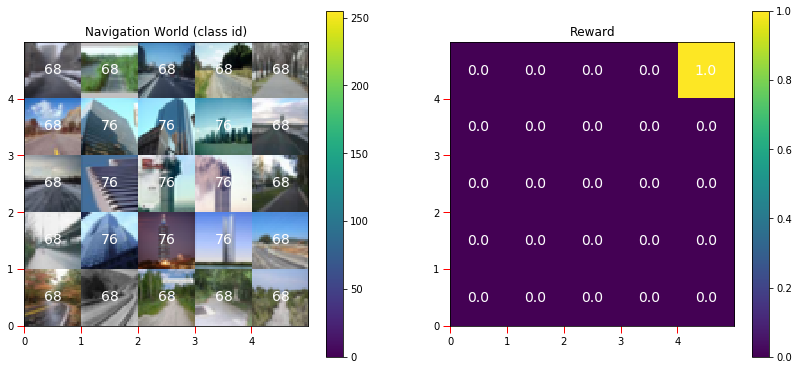

In [4]:
PHI_gridded_vis = np.flip(PHI_gridded, 2) # flip images vertically for cartesian system

fig = plt.figure(figsize=(14,14))
state_ann_sz = 14
state_ann_color = "white"
plt.subplot(2,2,1)
p = NavGridView(PHI_gridded_vis, ax=plt.gca()).render().ticks(minor=False).show_cell_text(
    S.class_ids, fontsize=state_ann_sz, color_cb=lambda x: state_ann_color).title("Navigation World (class id)")
plt.colorbar(p.im)
p.ax.invert_yaxis() # cartesian coordinates

plt.subplot(2,2,2)
p = NavGridView(R[..., np.newaxis, np.newaxis, np.newaxis], ax=plt.gca()).render().ticks(minor=False).show_cell_text(
    R, fontsize=state_ann_sz, color_cb=lambda x: state_ann_color).title("Reward")
plt.colorbar(p.im)
p.ax.invert_yaxis() # cartesian coordinates